In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import random
from scipy.stats import bernoulli

from exchange import *
from agents import *
from simulation import *

plt.rcParams['figure.dpi'] = 300

# Define MainCharacter Policy

In [3]:
def execute_policy(e: Exchange, price_function, policy_number: int):
    # main character params: true_value, quantity, side, spread, cid

    if list(e.bids.keys()) != [] and list(e.asks.keys()) != []:
        tob_bid = max(e.bids.keys())
        tob_ask = min(e.asks.keys())
    else: 
        return
    current_true_value = price_function(e.get_timestamp())

    policies = []

    ### quote 6 wide around 100 ###
    policies.append(MainCharacter(true_value=100, quantity=10, side="AB", spread=3, cid=-1.5))

    ### quote 2 wide around 100 ### 
    policies.append(MainCharacter(true_value=100, quantity=10, side="AB", spread=1, cid=-2.5))

    ### quote 2 wide around 100, quantity 1 ###
    policies.append(MainCharacter(true_value=100, quantity=1, side="AB", spread=1, cid=-3.5))

    ### quote 2 wide around true val (perfect information) ###
    policies.append(MainCharacter(true_value = price_function(e.get_timestamp()), quantity=5, side="AB", spread=1, cid=-4.5))

    ### quote 2 wide around true val 10 timestamps ago ### 
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() - 10), quantity=5, side="AB", spread=1, cid=-5.5))

    ### quote 2 wide around true value 10 timestamps into future ###
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() + 10), quantity=5, side="AB", spread=1, cid=-6.5))

    ### quote 6 wide around true value  ###
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() + 10), quantity=5, side="AB", spread=3, cid=-7.5))

    ### psychic far looking wide policy ###
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() + 50), quantity=5, side="AB", spread=3, cid=-8.5))

    if policy_number <= 7:
        a = policies[policy_number]
        if a.cid not in list(e.ask_customers.keys()) and a.cid not in list(e.bid_customers.keys()):
            e.add_order(a)
        return

    ### quote 1 ticks from top of book ### 
    if policy_number == 8:
        b = MainCharacter(true_value=tob_bid, quantity=5, side="B", spread=1, cid=-9.5)
        a = MainCharacter(true_value=tob_ask, quantity=5, side="A", spread=1, cid=-9.5)
        if a.cid not in list(e.ask_customers.keys()):
            e.add_order(a)
        if b.cid not in list(e.bid_customers.keys()):
            e.add_order(b)

    ### long-short taking strategy, perfect information ###
    if policy_number == 9:
        if tob_ask < price_function(e.get_timestamp()):
            b = MainCharacter(true_value=tob_ask, quantity=min(10, e.asks[tob_ask]), side="B", spread=0, cid=-10.5)
            e.add_order(b)
        if tob_bid > price_function(e.get_timestamp()):
            a = MainCharacter(true_value=tob_bid, quantity=min(10, e.bids[tob_bid]), side="A", spread=0, cid=-10.5)
            e.add_order(a)

    ### taking strategy, lagged information ###
    if policy_number == 10:
        if tob_ask < price_function(e.get_timestamp() - 10):
            b = MainCharacter(true_value=tob_ask, quantity=min(10, e.asks[tob_ask]), side="B", spread=0, cid=-10.5)
            e.add_order(b)
        if tob_bid > price_function(e.get_timestamp() - 10):
            a = MainCharacter(true_value=tob_bid, quantity=min(10, e.bids[tob_bid]), side="A", spread=0, cid=-10.5)
            e.add_order(a)

# Define Price Function

In [4]:
price_functions = []

### constant price ###
price_functions.append(lambda t: 100)

### linear increasing price ###
price_functions.append(lambda t: 0.003*t + 100)

### linear decreasing price ###
price_functions.append(lambda t: -0.003*t + 100)

### polynomial increasing price ### 
price_functions.append(lambda t: abs((t + 20) ** 0.5 + 100))

### polynomial decreasing price ### 
price_functions.append(lambda t: -(t + 20) ** 0.5 + 200)

### sine fluctuating ###
price_functions.append(lambda t: np.sin(t / 500) * 10 + 100)

### exponential ###
price_functions.append(lambda t: t * np.exp(t / 10000) + 100)

### polynomial sine ### 
price_functions.append(lambda t: abs(-0.000005 * t ** 2 + 0.05 * t + 100 + np.sin(t / 500) * 30))

Text(0.5, 0, 'timestamp')

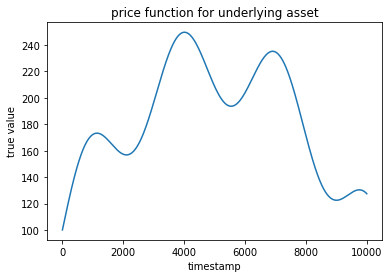

In [5]:
times = range(10000)
plt.plot([price_functions[-1](t) for t in times])
plt.title("price function for underlying asset")
plt.ylabel("true value")
plt.xlabel("timestamp")

# Run Simulation

In [7]:
agent_arrival_rate = 10
taker_probability = 0.4
num_agents = 20

### ToB policy

In [40]:
%%capture

policy_num = 8

price_fnc_data = []
for price_function in price_functions:
    profits = []
    ranks = []
    exchanges = []
    summaries = []
    for iteration in range(20):
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0
            rank = None
        else:
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)
    price_fnc_data.append((profits, ranks, exchanges, summaries))

In [41]:
[np.mean(arr[0]) for arr in price_fnc_data]

[4221.7,
 -291763.35231339966,
 -297008.624411258,
 -257246.4817866899,
 -257479.8155612399,
 16753.895519222468,
 -1188604143609.4976,
 -27562154.544872887]

In [42]:
[np.mean(arr[1]) for arr in price_fnc_data]

[1.0, 21.0, 21.0, 21.0, 21.0, 1.0, 21.0, 21.0]

### Taking Strategy | perfect information

In [43]:
%%capture

policy_num = 9

price_fnc_data = []
for price_function in price_functions:
    profits = []
    ranks = []
    exchanges = []
    summaries = []
    for iteration in range(20):
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0
            rank = None
        else:
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)
    price_fnc_data.append((profits, ranks, exchanges, summaries))

In [44]:
[np.mean(arr[0]) for arr in price_fnc_data]

[1173.55,
 280829.9506733885,
 289420.47719849146,
 302471.27605966607,
 300050.02466882305,
 704.4269307570995,
 37894763725703.65,
 368421811.3672002]

In [45]:
[np.mean(arr[1]) for arr in price_fnc_data]

[1.0, 1.0, 1.0, 1.0, 1.0, 6.95, 1.0, 1.0]

### Taking Strategy | lagged information

In [8]:
%%capture

policy_num = 10

price_fnc_data = []
for price_function in price_functions:
    profits = []
    ranks = []
    exchanges = []
    summaries = []
    for iteration in range(20):
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0
            rank = None
        else:
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)
    price_fnc_data.append((profits, ranks, exchanges, summaries))

In [9]:
[np.mean(arr[0]) for arr in price_fnc_data]

[1174.9,
 267461.95207238593,
 271390.2203591876,
 298961.5029073904,
 300521.2730514021,
 1453.8540187114256,
 3488126983562.7715,
 237795411.37834603]

In [10]:
[np.mean(arr[1]) for arr in price_fnc_data]

[1.0, 1.0, 1.0, 1.0, 1.0, 7.75, 1.0, 1.0]

### Constant Price Function

In [11]:
%%capture

price_function = lambda t: 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))

In [12]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[383.0, 5389.0, 1072.1, 3600.1, 3631.4, 3641.95, 291.9, 302.5]

In [13]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[1.15, 1.0, 1.0, 1.0, 1.0, 1.0, 1.3, 1.25]

## Linear Increasing Price Function

In [14]:
%%capture

price_function = lambda t: 0.003*t + 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))

In [15]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[-579067.5335808898,
 -584569.2041773944,
 -58554.52357467343,
 11167.75975289724,
 8714.895870348526,
 15272.449497841551,
 91.64634083763562,
 5643.195354499878]

In [16]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[21.0, 21.0, 21.0, 4.4, 6.0, 2.95, 10.55, 6.7]

## Sine Price Function

In [17]:
%%capture

price_function = lambda t: np.sin(t / 500) * 10 + 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

In [18]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[9725.819436286369,
 6236.591855083339,
 666.0185845184794,
 1181.4769093658715,
 1077.9007044981256,
 876.3014570537083,
 700.233053157951,
 239.43195166746017]

In [19]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[1.0, 1.0, 2.85, 2.6, 2.15, 3.75, 4.0, 8.1]

## Exponential Price Function

In [20]:
%%capture

price_function = lambda t: t * np.exp(t / 10000) + 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

In [21]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[-745925824420.6061,
 -681775128778.2341,
 -85977492321.61264,
 -117575255497.75793,
 -236750606636.59985,
 -71209653161.79327,
 -76351237162.2475,
 -5136400758.255139]

In [22]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[20.95, 21.0, 16.45, 18.4, 20.35, 16.15, 16.7, 11.2]

## Linear Decreasing Function

In [23]:
%%capture

price_function = lambda t: -0.003*t + 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))

In [24]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[-580255.807022617,
 -585456.9428383501,
 -58553.953740599754,
 14085.875545798981,
 8830.05943614383,
 16654.288422981965,
 227.71290267254707,
 4134.179477909954]

In [25]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[21.0, 21.0, 21.0, 3.1, 5.85, 2.15, 11.05, 7.95]

## Polynomial Increasing Function

In [26]:
%%capture

price_function = lambda t: (t + 20) ** 0.5 + 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))

In [27]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[-615064.5772579995,
 -619633.6944633244,
 -61966.63652243816,
 9245.200508932248,
 6162.386402832097,
 9736.90525286622,
 2386.6719482158687,
 8083.476317323036]

In [28]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[21.0, 21.0, 21.0, 3.3, 5.9, 3.2, 9.15, 3.6]

## Polynomial Decreasing Function

In [29]:
%%capture

price_function = lambda t: -(t+20) ** 0.5 + 200

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))

In [30]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[-331843.4395613974,
 -336047.6474343749,
 -33676.05339813252,
 9782.43724261359,
 5168.982300115689,
 11709.875598798746,
 1660.0150268440448,
 7315.154935555879]

In [31]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[21.0, 21.0, 21.0, 3.0, 7.05, 3.3, 8.45, 4.15]

## Polynomial Sine

In [32]:
price_function = lambda t: abs(-0.000005 * t ** 2 + 0.05 * t + 100 + np.sin(t / 500) * 30)

In [33]:
%%capture
# price_function = lambda t: -0.000005 * (t + 50) ** 2 + 0.05 * (t+50) + 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=agent_arrival_rate, taker_probability=taker_probability, n=100000) 
        summary, profit = summarize_transactions(e, price_function, num_agents=num_agents)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))

In [34]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[-17142614.393677287,
 -18635574.460927326,
 -2297874.908947463,
 -1737759.5722625614,
 -2173350.336176459,
 -994623.2802674093,
 -1039427.1521852255,
 -139578.0721208909]

In [35]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[21.0, 21.0, 18.65, 17.8, 18.55, 14.9, 15.95, 12.15]